In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
datset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
    
)

Found 1320 files belonging to 10 classes.


In [3]:
class_name = datset.class_names
class_name

['Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato_healthy',
 'Tomato_mosaic_virus']

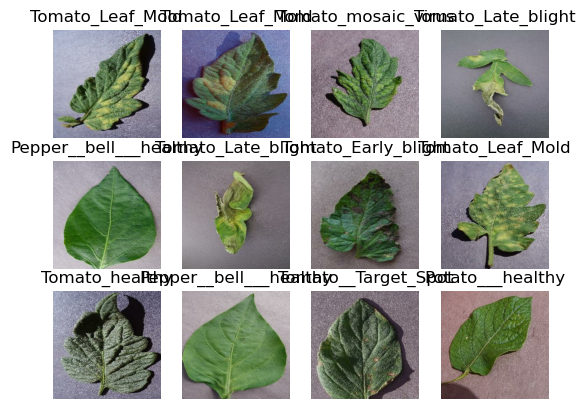

In [4]:
for image, image_lable in datset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_name[image_lable[i]])
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
train_size = 0.8
len(datset)*train_size

33.6

In [6]:

test_ds = datset.skip(54)
len(test_ds)

0

In [7]:
val_size = 0.1
len(datset)*val_size

4.2

In [8]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [9]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [10]:
def get_dataset_from_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds


In [11]:
train_ds, val_ds, test_ds = get_dataset_from_partitions(datset)

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256,256),
    tf.keras.layers.Rescaling(1.0/256)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [15]:
input_shape = (32,256,256,3)

In [17]:
# Assuming you have the number of classes stored in a variable called num_classes
num_classes = 10 # for example

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(1024, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(2024, activation='relu'),
    layers.Dropout(0.2),  # Adding dropout for regularization
    layers.Dense(num_classes, activation='softmax')  # Corrected the last dense layer
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with your data
history = model.fit(
    train_ds,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.1075 - loss: 2.3365 - val_accuracy: 0.2266 - val_loss: 2.2928
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.1240 - loss: 2.2930 - val_accuracy: 0.2109 - val_loss: 2.1808
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.1465 - loss: 2.2483 - val_accuracy: 0.0625 - val_loss: 2.2993
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.1089 - loss: 2.3001 - val_accuracy: 0.0625 - val_loss: 2.3004
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.1218 - loss: 2.2923 - val_accuracy: 0.0625 - val_loss: 2.2904
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.1346 - loss: 2.2430 - val_accuracy: 0.2188 - val_loss: 1.9836
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.1919 - loss: 2.0466 - val_accuracy: 0.1797 - val_loss: 2.1439
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.2223 - loss: 2.1191 - val_accuracy: 0.

In [18]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step - accuracy: 0.8715 - loss: 0.4360


In [39]:
scores = model.evaluate(test_ds)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.8780 - loss: 0.4253


In [20]:
scores

[0.38386231660842896, 0.875]

In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 33}

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

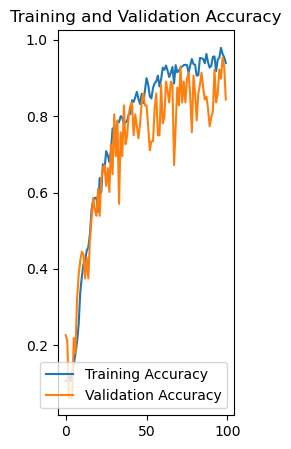

In [25]:
import matplotlib.pyplot as plt

# Assuming you have defined the variables 'epochs', 'acc', and 'val_acc' elsewhere in your code
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)

min_length = min(len(acc), len(val_acc))  # Find the minimum length of acc and val_acc

plt.plot(range(min_length), acc[:min_length], label='Training Accuracy')
plt.plot(range(min_length), val_acc[:min_length], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()




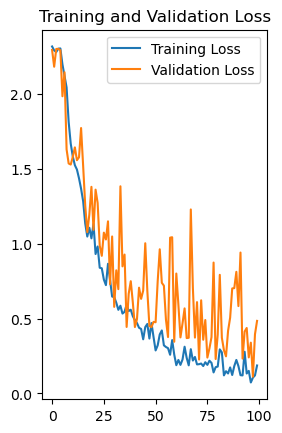

In [27]:
EPOCHS = 100  # For example, you should replace 50 with the actual number of epochs used during training

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to pridict
the  actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
predicted label: Pepper__bell___healthy


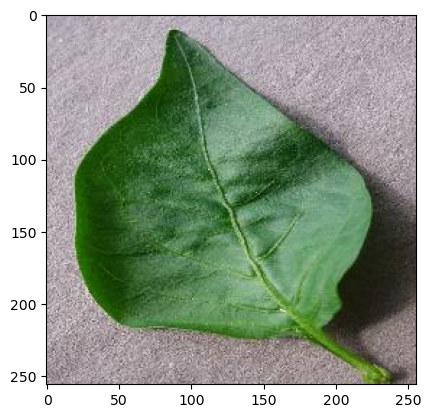

In [29]:
for image, image_label in test_ds.take(1):
    first_image = image[0].numpy().astype('uint8')
    first_label = image_label[0].numpy()
    print("first image to pridict")
    plt.imshow(first_image)
    print("the  actual label:", class_name[first_label])
    batch_prediction = model.predict(image)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


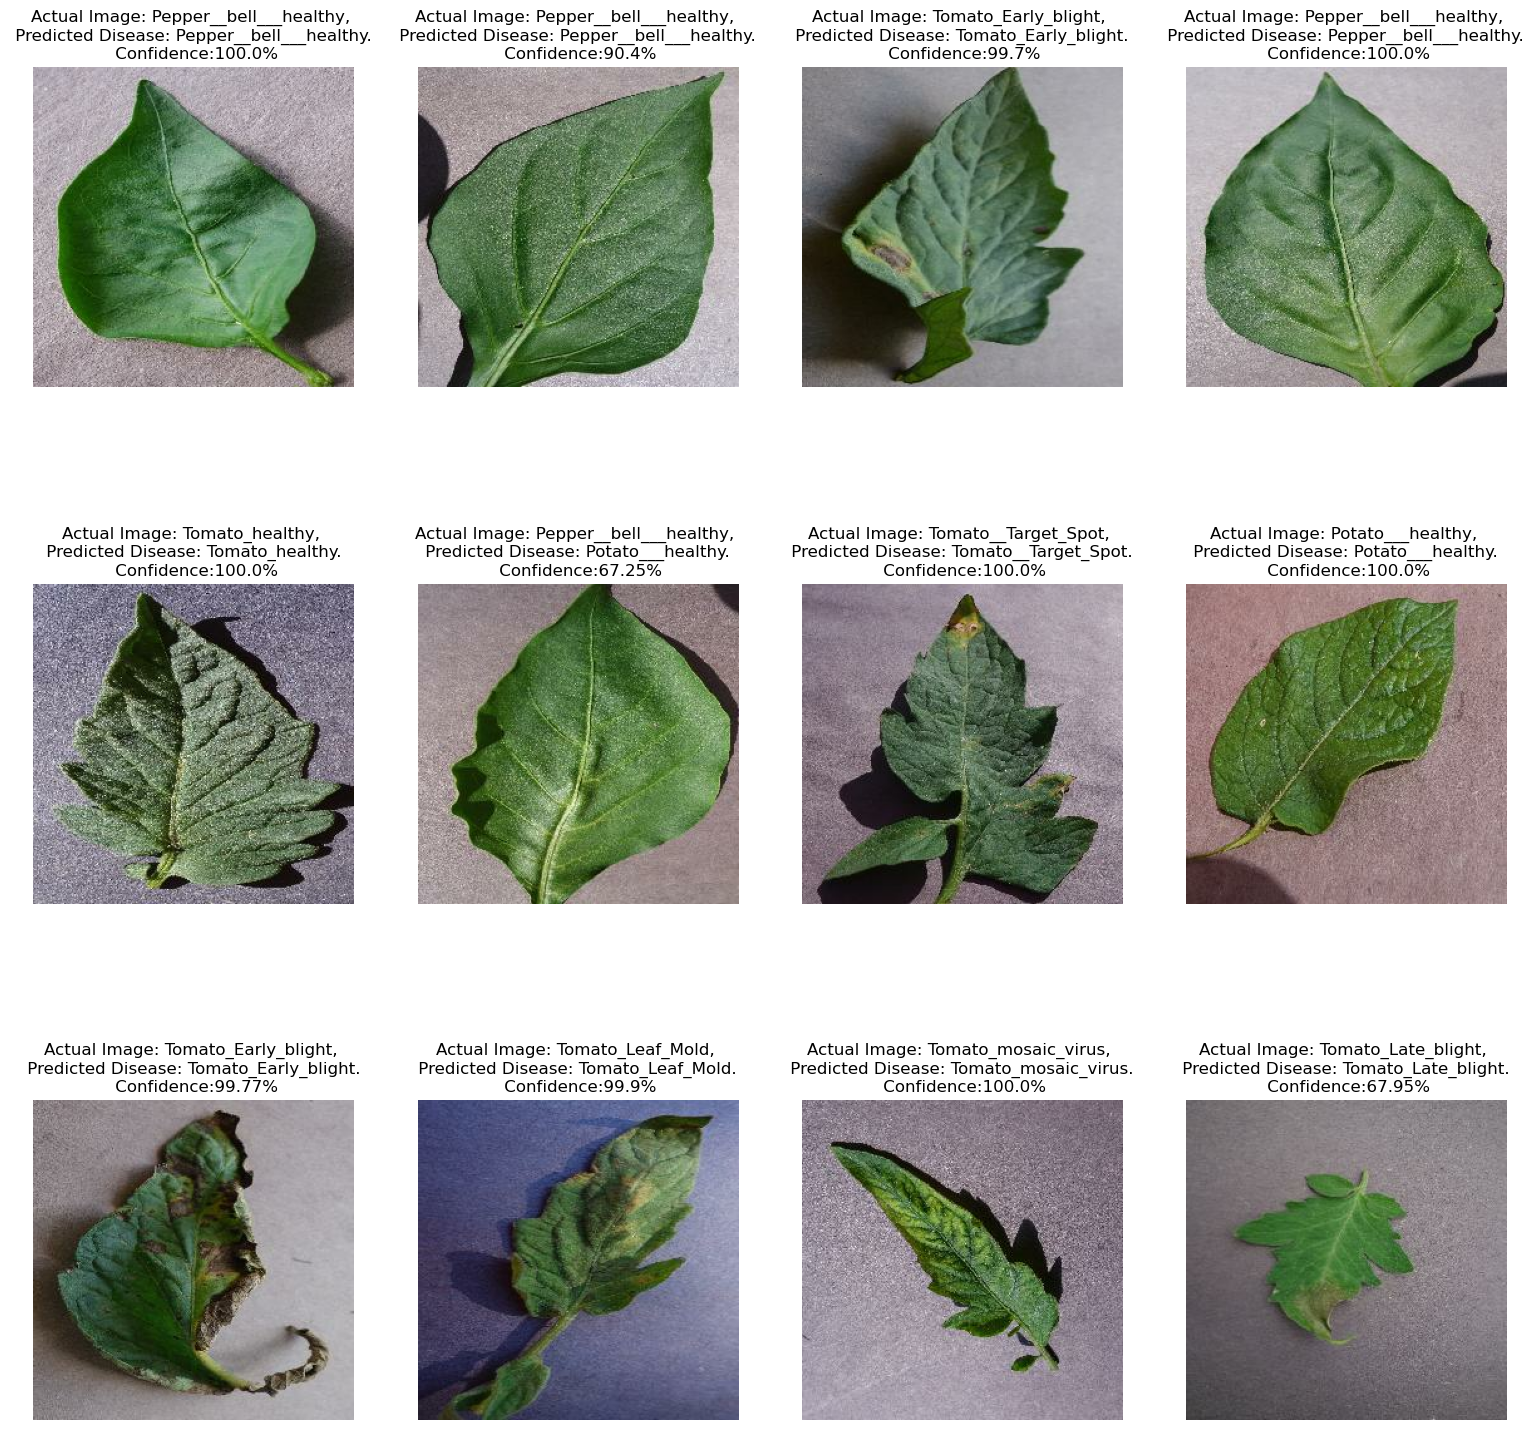

In [42]:
plt.figure(figsize=(19,19))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        plt.title(f"Actual Image: {actual_class}, \n Predicted Disease: {predicted_class}. \n Confidence:{confidence}%")
        plt.axis("off")

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("D:\Tr_model")+ [0]])+1
tf.saved_model.save(model,f"D:\Tr_model\{model_version}")

In [ ]:
import os
import tensorflow as tf

model_version = max([int(i) for i in os.listdir("D:\Tr_model") + [0]]) + 1

# Assuming 'model' is your trained model and 'history' is your training history
# Replace 'your_input_tensor' with the input tensor(s) of your model
input_signature = tf.TensorSpec(shape=model.input_shape, dtype=model.dtype)

@tf.function(input_signature=[input_signature])
def serving_default(input_tensor):
    return {'output': model(input_tensor)}

tf.saved_model.save(model, 'D:\Tr_model\{}'.format(model_version), signatures={'serving_default': serving_default})
